# Advanced Microeconometrics 2023 Final Exam: Getting Started with the Data

*9:00 am January 13th to 9:00 am January 15th, 2024* 

The code herein is merely intended as a help for reading in the data. You are free to disregard it entirely. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.stats import norm
from scipy import optimize

import estimation as est
import LinearModels as lm
import SampleSelection_post as ssm

# Cross Sectional Data

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# There are outcomes (y) missing and s indicates which outcomes are not missing
data.head(20)

,y,x,s
0,NaN,-0.617175,0.0
1,NaN,0.362635,0.0
2,NaN,0.123566,0.0
3,NaN,1.305788,0.0
4,NaN,-1.258760,0.0
5,NaN,-0.937543,0.0
6,3.573326,0.793135,1.0
7,3.275980,1.263474,1.0
8,NaN,-1.657206,0.0
9,3.246213,1.421604,1.0


In [4]:
data.describe()

,y,x,s
count,448.000000,1000.000000,1000.000000
mean,1.415272,0.014009,0.448000
std,1.955411,0.994254,0.497537
min,-4.486865,-3.049044,0.000000
25%,-0.027941,-0.637182,0.000000
50%,1.286428,-0.027879,0.000000
75%,2.633311,0.700595,1.000000
max,9.265470,4.279818,1.000000


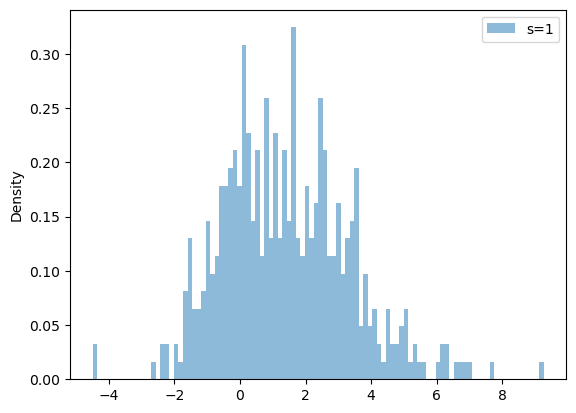

In [5]:
# Plot histograms
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.plot(data['y'][data['s'] == 1], alpha=0.5)
ax.hist(data['y'][data['s'] == 1], bins=100, alpha=0.5, density=True) 
ax.legend(['s=1', 's=0'])
ax.set_ylabel('Density');

In [6]:
# We want to check for missings and remove them, but only for variables that we are interested in.
# We therefore gather all the labels into one "check_missing" label.
xlbl = ['delta', 'eta']
ylbl = 'y'
slbl = 's' # exclusion restriction, s == 0 

In [7]:
# Extracting the data
y = data['y'].values.reshape(-1, 1)
x = data['x'].values.reshape(-1, 1)
s = data['s'].values.reshape(-1, 1)

## Heckit

### 7. 

In [8]:
# a. estimate the first Heckit step 
first_step = est.estimate(ssm.q, ssm.starting_values(s, x), s, x, cov_type='Sandwich')

# b. print the results 
est.print_table(xlbl, first_step, title='First step results')

Optimization terminated successfully.
         Current function value: 0.429875
         Iterations: 10
         Function evaluations: 33
         Gradient evaluations: 11
Optimizer succeded after 10 iter. (33 func. evals.). Final criterion:   0.4299.
First step results


,theta,se,t
delta,1.5041,0.0909,16.5397
eta,0.4888,0.0566,8.6306


In [9]:
# extract delta and eta from the results
delta = first_step['theta'][0]
eta = first_step['theta'][1]

### 9.

In [10]:
# a. estimate the PE
PE = norm.pdf(x*delta) * delta

# b. print the results
print('PE: ', PE[0][0].round(4))

PE:  0.39


In [11]:
# a. find the stadard errors of delta
i = 0
bb = np.outer(delta,delta)
xx = np.outer(x[i], x[i])
I_K = np.eye(1)
gx0 = norm.pdf(x[i]*delta)

# b. the gradient 
grad_c_pr = gx0@(I_K - bb @ xx)

# c. the standard errors function 
def get_se(grad, cov):
    cov_me = grad*cov*grad.T
    return np.sqrt(np.diag(cov_me))

# d. extract the standard errors
se_c_pr = get_se(grad_c_pr, first_step['cov'][0])

In [12]:
# a. make a table of the results 
me_dict = {'Marginal Effect': PE[0], 's.e.': se_c_pr[0,0]}
tab = pd.DataFrame(me_dict,index=['PE'])
tab['t'] = tab['Marginal Effect'] / tab['s.e.']
tab.index.name = 'Var'
tab.round(4)

,Marginal Effect,s.e.,t
Var,,,
PE,0.39,0.0033,119.6143


### 11.

In [13]:
# a. estimating inverse Mills ratios
xb = x*first_step['theta'][0]
_lambda = norm.pdf(xb)/norm.cdf(xb)

# b. for only the sample of s=1
_lambda = _lambda[s.flatten() == 1]
print('Estimated lambda: ', _lambda.mean().round(4))

Estimated lambda:  0.423


In [14]:
# set the x and y with s=1
I = s.flatten() == 1
x_new = x[I]
y_new = y[I]

In [15]:
# add the IMR as a generated regressor
ximr = np.hstack((_lambda.reshape(-1, 1), x_new))

In [16]:
# lbel the new regressors
x_newlbl = ['beta']
xlblimr = x_newlbl.copy()
xlblimr.insert(0, 'gamma')

In [17]:
# a. estimate the second step of the Heckit model
second_step = lm.estimate(y_new, ximr)

# b. print the results
lm.print_table((ylbl, xlblimr), second_step, 
    title="Results accounting for selection", floatfmt='.4f')

Results accounting for selection
Dependent variable: y

          Beta      Se    t-values
-----  -------  ------  ----------
gamma  -0.0300  0.0956     -0.3144
beta    2.0885  0.0639     32.6720
R² = 0.625
σ² = 1.439


/Users/juliekrabek/anaconda3/lib/python3.11/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
